# Import Libraries 

In [1]:
from tqdm import tqdm
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from   torchvision import datasets, transforms
import torch.optim as optim
from   torch.optim.lr_scheduler import StepLR
from   torchinfo import summary

import albumentations as A
from   albumentations.pytorch import ToTensorV2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import models as cifar_models
import utils as myutils

# Set the GPU device

In [2]:
# Is GPU available
device = torch.device("cpu")
is_gpu_available = False

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda:0")
    is_gpu_available = True
elif torch.backends.mps.is_available():
    print("Apple MPS is available")
    device = torch.device("mps:0")
    is_gpu_available = True

torch.set_default_device(device)

Apple MPS is available


# Download and prepare the dataset

In [3]:
# To get over the following error:
# URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
batch_size = 2048
# Train Phase transformations
# train_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     transforms.ToTensor(),
# ])
train_transforms = myutils.Transforms(transforms=A.Compose([
    A.HorizontalFlip(p=0.25),
    A.ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, 
        border_mode=4, value=None, mask_value=None, shift_limit_x=None, shift_limit_y=None, 
        rotate_method='largest_box', always_apply=False, p=0.5,
    ),
    A.CoarseDropout(
        max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
        min_width=16, fill_value=0.48, mask_fill_value=None, always_apply=False, p=0.5,
    ),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(),
]))

# Test Phase transformations
# test_transforms = transforms.Compose([
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     transforms.ToTensor(),
# ])
test_transforms = myutils.Transforms(transforms=A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(),
]))

# Data
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# Data loaders
dataloader_args = dict(shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True) if is_gpu_available else dict(shuffle=True, batch_size=64)

# train dataloader
train_data_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)
# test dataloader
test_data_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

print("classes: ", train_data.class_to_idx)
# {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
classes:  {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


## Look at the data

In [5]:
# # functions to show an image
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images
# dataiter = iter(train_data_loader)
# images, labels = next(dataiter)
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# # show images
# imshow(torchvision.utils.make_grid(images[:4]))
# # print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Model

# Summary

In [6]:
model = cifar_models.Net().to(device)
summary(model=model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           4,736
│    └─ReLU: 2-2                         [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 32, 32, 32]           64
│    └─Dropout: 2-4                      [1, 32, 32, 32]           --
├─Sequential: 1-2                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 32, 32, 32]           832
│    └─ReLU: 2-6                         [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 32, 32, 32]           64
│    └─Dropout: 2-8                      [1, 32, 32, 32]           --
├─Sequential: 1-3                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 64, 32, 32]           2,112
│    └─R

# Train and test the model

In [7]:
model = cifar_models.Net().to(device)

criterion = F.nll_loss
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimiser, step_size=6, gamma=0.1)

train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 20
for epoch in range(EPOCHS):
    # print("EPOCH:", epoch)
    myutils.train(model, train_data_loader, criterion, optimizer, epoch, train_losses, train_acc, device)
    # scheduler.step()
    myutils.test(model, test_data_loader, epoch, test_losses, test_acc, device)

Epoch=0 Batch_id=24 Loss=2.0139284133911133 Accuracy=19.80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.58s/it]



Test set: Average loss: 2.1760, Accuracy: 1720/10000 (17.20%)



Epoch=1 Batch_id=24 Loss=1.9195501804351807 Accuracy=25.92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.49s/it]



Test set: Average loss: 1.8972, Accuracy: 2769/10000 (27.69%)



Epoch=2 Batch_id=24 Loss=1.8363786935806274 Accuracy=29.53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.49s/it]



Test set: Average loss: 1.7970, Accuracy: 3266/10000 (32.66%)



Epoch=3 Batch_id=24 Loss=1.7641404867172241 Accuracy=32.29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.49s/it]



Test set: Average loss: 1.7351, Accuracy: 3539/10000 (35.39%)



Epoch=4 Batch_id=24 Loss=1.7250901460647583 Accuracy=34.14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.49s/it]



Test set: Average loss: 1.6902, Accuracy: 3728/10000 (37.28%)



Epoch=5 Batch_id=24 Loss=1.7020989656448364 Accuracy=35.43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.49s/it]



Test set: Average loss: 1.6501, Accuracy: 3935/10000 (39.35%)



Epoch=6 Batch_id=24 Loss=1.694251537322998 Accuracy=36.96: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.49s/it]



Test set: Average loss: 1.6084, Accuracy: 4067/10000 (40.67%)



Epoch=7 Batch_id=24 Loss=1.6639111042022705 Accuracy=37.80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.6135, Accuracy: 4075/10000 (40.75%)



Epoch=8 Batch_id=24 Loss=1.6303391456604004 Accuracy=38.46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.5539, Accuracy: 4263/10000 (42.63%)



Epoch=9 Batch_id=24 Loss=1.6203439235687256 Accuracy=39.52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.5309, Accuracy: 4383/10000 (43.83%)



Epoch=10 Batch_id=24 Loss=1.579413652420044 Accuracy=40.40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.5212, Accuracy: 4456/10000 (44.56%)



Epoch=11 Batch_id=24 Loss=1.603068470954895 Accuracy=41.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.4870, Accuracy: 4562/10000 (45.62%)



Epoch=12 Batch_id=24 Loss=1.5602459907531738 Accuracy=41.27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.4854, Accuracy: 4563/10000 (45.63%)



Epoch=13 Batch_id=24 Loss=1.5463064908981323 Accuracy=42.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.4861, Accuracy: 4614/10000 (46.14%)



Epoch=14 Batch_id=24 Loss=1.527945637702942 Accuracy=42.85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.48s/it]



Test set: Average loss: 1.4304, Accuracy: 4799/10000 (47.99%)



Epoch=15 Batch_id=24 Loss=1.5244272947311401 Accuracy=43.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.49s/it]



Test set: Average loss: 1.4427, Accuracy: 4765/10000 (47.65%)



Epoch=16 Batch_id=24 Loss=1.5282930135726929 Accuracy=43.65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.4289, Accuracy: 4814/10000 (48.14%)



Epoch=17 Batch_id=24 Loss=1.5116534233093262 Accuracy=44.42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.4013, Accuracy: 4958/10000 (49.58%)



Epoch=18 Batch_id=24 Loss=1.474474549293518 Accuracy=45.15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.50s/it]



Test set: Average loss: 1.4063, Accuracy: 4936/10000 (49.36%)



Epoch=19 Batch_id=24 Loss=1.4665969610214233 Accuracy=45.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:36<00:00,  1.48s/it]



Test set: Average loss: 1.3809, Accuracy: 5042/10000 (50.42%)



# Visualise

## Training and Testing

Text(0.5, 1.0, 'Test Accuracy')

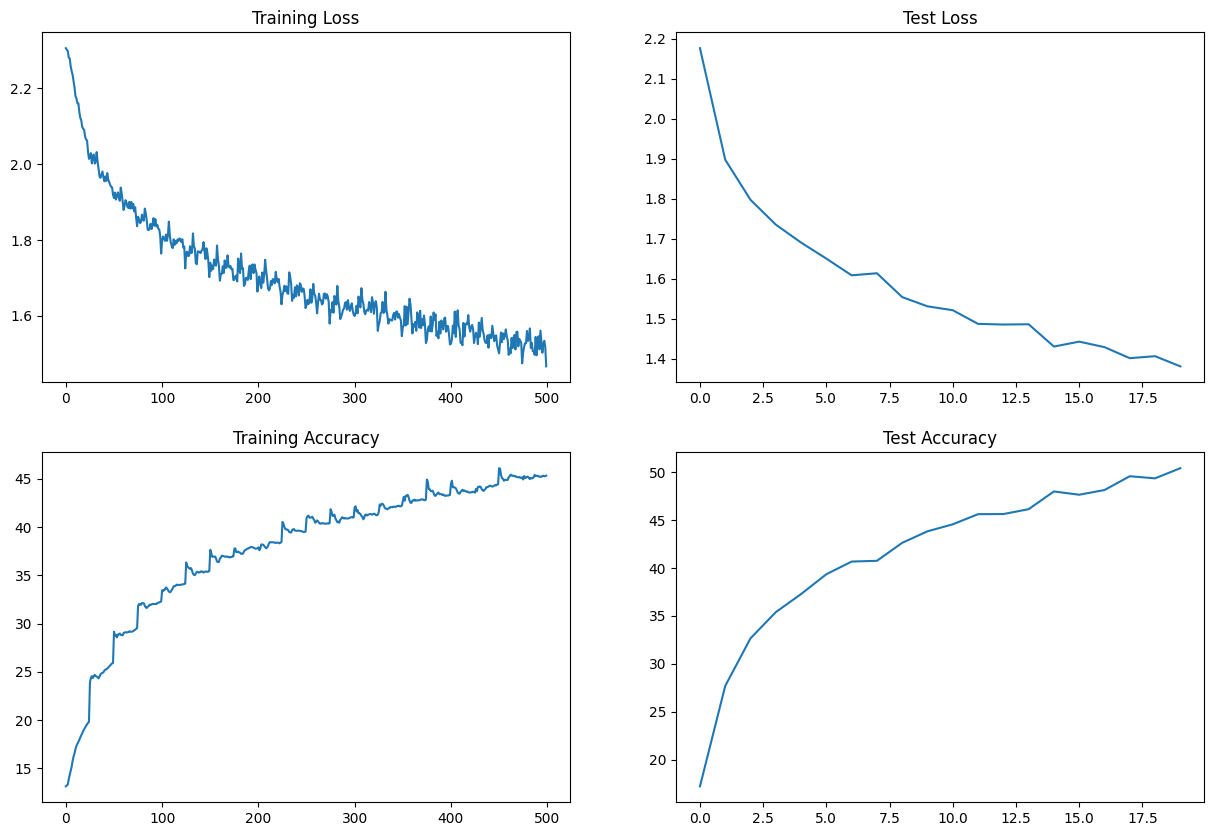

In [9]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")